In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

import matplotlib.image as mpimg

from ssd_k2 import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

from PIL import ImageEnhance
from PIL import Image as pil_image

from timeit import default_timer as timer

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

## Loading Model 

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [4]:
inputs = []
images = []
img_path = './pics/fish-bike.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './pics/cat.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './pics/boys.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './pics/car_cat.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = './pics/car_cat2.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [4]:
inputs = []
images = []

import os 
import glob

files = glob.glob("./test_images/*.jpg")

pipeline_images = [ mpimg.imread(file) for file in files ]
pim = [pil_image.fromarray(im) for im in pipeline_images]


print(files)

for img_path in files[:1]:
    #img_path = './pics/fish-bike.jpg'
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())

inputs = preprocess_input(np.array(inputs))

['./test_images/test6.jpg', './test_images/test5.jpg', './test_images/test4.jpg', './test_images/test1.jpg', './test_images/test3.jpg', './test_images/test2.jpg']


In [49]:
img_resize = pim[0].resize((300,300), pil_image.NEAREST)

In [12]:
from skimage.transform import resize
im  = resize(pipeline_images[0],(300,300), mode="reflect")
print(im.shape)
inputs = preprocess_input(np.array(im))

(300, 300, 3)


In [39]:
preds = model.predict(inputs, batch_size=1, verbose=1)

1/1 [==============================] - 1s


In [40]:
results = bbox_util.detection_out(preds)

In [61]:
len(results)

1

In [41]:
results[0][:,1]

array([ 0.94157994,  0.70454484,  0.10037807,  0.04385161,  0.03534717,
        0.03082876,  0.02799819,  0.02192873,  0.02097563,  0.0183836 ,
        0.01768432,  0.01597903,  0.01533224,  0.01479978,  0.01406449,
        0.013548  ,  0.01152659,  0.01137065,  0.01121401,  0.01080092,
        0.0104225 ,  0.01019755])

In [42]:
top_indices = [i for i, conf in enumerate(results[0][:,1]) if conf >= 0.6]
top_indices

[0, 1]

In [26]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

CPU times: user 32.7 s, sys: 1.49 s, total: 34.2 s
Wall time: 9.69 s


object NO: 1
rectangle info:  ((811, 403), 133, 98)
object NO: 2
rectangle info:  ((1002, 407), 192, 97)


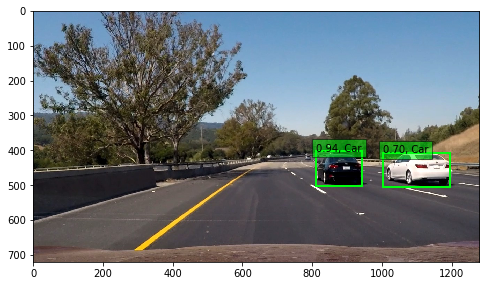

In [43]:
for i, img in enumerate(pipeline_images[:1]):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        
        if label_name != "Car":
            continue
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        print("object NO:", i+1)
        print("rectangle info: ", coords)
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

## Video Processing

In [5]:
video_path = "project_video.mp4"
vid = cv2.VideoCapture(video_path)

In [6]:
vidw = vid.get(3) # CV_CAP_PROP_FRAME_WIDTH
vidh = vid.get(4) # CV_CAP_PROP_FRAME_HEIGHT

print(vidw,vidh)
input_shape = (300,300,3)
vidar = vidw/vidh
print(vidar)

1280.0 720.0
1.7777777777777777


In [7]:
class_colors = []
class_names = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"];
NUM_CLASSES = len(class_names)

for i in range(0, NUM_CLASSES):
    # This can probably be written in a more elegant manner
    hue = 255*i/NUM_CLASSES
    col = np.zeros((1,1,3)).astype("uint8")
    col[0][0][0] = hue
    col[0][0][1] = 128 # Saturation
    col[0][0][2] = 255 # Value
    cvcol = cv2.cvtColor(col, cv2.COLOR_HSV2BGR)
    col = (int(cvcol[0][0][0]), int(cvcol[0][0][1]), int(cvcol[0][0][2]))
    class_colors.append(col) 

In [18]:
start_frame = 0
conf_thresh = 0.6

accum_time = 0
curr_fps = 0
fps = "FPS: ??"
prev_time = timer()

def pipeline(orig_image):
    
    input_shape = (300,300,3)
    im_size = (input_shape[0], input_shape[1])   
    resized = cv2.resize(orig_image, im_size)
    to_draw = cv2.resize(resized, (int(input_shape[0]*vidar), input_shape[1]))

    # Use model to predict 
    inputs = [image.img_to_array(resized)]
    tmp_inp = np.array(inputs)
    x = preprocess_input(tmp_inp)
    y = model.predict(x)
    
    #preds = model.predict(inputs, batch_size=1, verbose=1)
    results = bbox_util.detection_out(y)
    
    if len(results) > 0 and len(results[0]) > 0:
        # Interpret output, only one frame is used 
        det_label = results[0][:, 0]
        det_conf = results[0][:, 1]
        det_xmin = results[0][:, 2]
        det_ymin = results[0][:, 3]
        det_xmax = results[0][:, 4]
        det_ymax = results[0][:, 5]

        top_indices = [i for i, conf in enumerate(det_conf) if conf >= conf_thresh]

        top_conf = det_conf[top_indices]
        top_label_indices = det_label[top_indices].tolist()
        top_xmin = det_xmin[top_indices]
        top_ymin = det_ymin[top_indices]
        top_xmax = det_xmax[top_indices]
        top_ymax = det_ymax[top_indices]

        for i in range(top_conf.shape[0]):
            xmin = int(round(top_xmin[i] * to_draw.shape[1]))
            ymin = int(round(top_ymin[i] * to_draw.shape[0]))
            xmax = int(round(top_xmax[i] * to_draw.shape[1]))
            ymax = int(round(top_ymax[i] * to_draw.shape[0]))

            # Draw the box on top of the to_draw image
            class_num = int(top_label_indices[i])
            cv2.rectangle(to_draw, (xmin, ymin), (xmax, ymax), 
                          class_colors[class_num], 2)
            text = class_names[class_num] + " " + ('%.2f' % top_conf[i])

            text_top = (xmin, ymin-10)
            text_bot = (xmin + 80, ymin + 5)
            text_pos = (xmin + 5, ymin)
            #cv2.rectangle(to_draw, text_top, text_bot, class_colors[class_num], -1)
            #cv2.putText(to_draw, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1)
            
    # Calculate FPS
    # This computes FPS for everything, not just the model's execution 
    # which may or may not be what you want
    #curr_time = timer()
    #exec_time = curr_time - prev_time
    #prev_time = curr_time
    #accum_time = accum_time + exec_time
    #curr_fps = curr_fps + 1
    #if accum_time > 1:
    #    accum_time = accum_time - 1
    #    fps = "FPS: " + str(curr_fps)
    #    curr_fps = 0

    # Draw FPS in top left corner
    #cv2.rectangle(to_draw, (0,0), (50, 17), (255,255,255), -1)
    #cv2.putText(to_draw, fps, (3,10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,0,0), 1)

    #print("object NO:", i+1)
    #print("rectangle info: ", coords)
    
    
    return to_draw

In [19]:
test_draw = pipeline(pipeline_images[0])

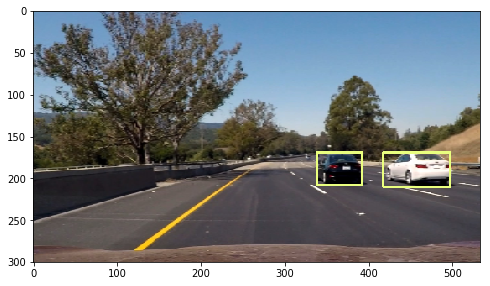

In [20]:
plt.imshow(test_draw)

In [21]:
## import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [22]:
video_output = 'test_images/project_video_sliding_found3.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_images/project_video_sliding_found3.mp4
[MoviePy] Writing video test_images/project_video_sliding_found3.mp4


100%|█████████▉| 1260/1261 [34:08<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_images/project_video_sliding_found3.mp4 

CPU times: user 1h 56min 38s, sys: 5min 21s, total: 2h 1min 59s
Wall time: 34min 9s
